#1. Carga de datos

## 1.1 Importar librerías

In [12]:
!pip install keras-tuner

In [22]:
import numpy as np
import pandas as pd
import joblib
from matplotlib import pyplot as plt
import cv2

from google.colab import drive

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn import metrics
from sklearn.metrics import (
    roc_curve, auc, RocCurveDisplay,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report , roc_auc_score
)
from sklearn.utils import class_weight

import keras_tuner as kt

## 1.2 Cargar bases de datos procesadas

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
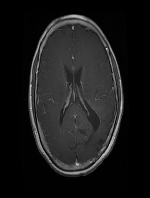

In [14]:
drive.mount('/content/drive')
x_train = joblib.load('/content/drive/MyDrive/cod/A3_helath/data/salidas/x_train.pkl')
y_train = joblib.load('/content/drive/MyDrive/cod/A3_helath/data/salidas/y_train.pkl')
x_test = joblib.load('/content/drive/MyDrive/cod/A3_helath/data/salidas/x_test.pkl')
y_test = joblib.load('/content/drive/MyDrive/cod/A3_helath/data/salidas/y_test.pkl')

x_train[0]

In [15]:
# Conversión a float32 para escalar
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [16]:
# Escalado entre 0 y 1
x_train /= 255
x_test /= 255

In [17]:
# Visualizar forma de las imagenes para luego convertir a 1D
print("Shape x_train:", x_train.shape)
print("Shape x_test:", x_test.shape)

Shape x_train: (5712, 198, 150, 3)
Shape x_test: (1311, 198, 150, 3)


In [18]:
np.prod(x_train[1].shape) # cantidad de variables por imagen

np.int64(89100)

In [19]:
np.unique(y_train, return_counts=True)
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3]), array([300, 306, 300, 405]))

#2. Modelos

##2.1 Red Neuronal Convolucional NNC

In [20]:
# Cantidad de clases
num_classes = len(np.unique(y_train))
print(f"Número de clases detectadas: {num_classes}")

cnn_model = Sequential()

# Primera capa convolucional y de pooling
# input_shape es solo para la primera capa
# Conv2D: 32 filtros, tamaño del filtro 3x3, activación ReLU
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=x_train.shape[1:]))
# MaxPooling2D: Ventana de pooling 2x2. Reduce la resolución a la mitad.
cnn_model.add(MaxPooling2D((2, 2)))

# Segunda capa convolucional y de pooling
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))

# Aplanar la salida de las capas convolucionales antes de las capas densas
cnn_model.add(Flatten())

# Capas densas (como en tu modelo anterior)
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(64, activation='relu'))

# Capa de salida para clasificación multiclase (con softmax y num_classes)
cnn_model.add(Dense(num_classes, activation='softmax'))

# Compilar el modelo
cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy']) # Añadir más métricas si deseamos, como AUC, Recall, Precision

# Mostrar un resumen de la arquitectura del modelo
cnn_model.summary()

# Guardar el mejor modelo
checkpoint = ModelCheckpoint("mejor_cnn_modelo.keras", monitor="val_accuracy", save_best_only=True, mode='max', verbose=1)

# Entrenamiento
history = cnn_model.fit(x_train, y_train,
                        batch_size=100,
                        epochs=5,
                        validation_data=(x_test, y_test),
                        callbacks=[checkpoint])

Número de clases detectadas: 4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 196, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 98, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 96, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 110592)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,155,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,183,812 (54.11 MB)

 Trainable params: 14,183,812 (54.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.4723 - loss: 1.5076
Epoch 1: val_accuracy improved from -inf to 0.73074, saving model to mejor_cnn_modelo.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 187ms/step - accuracy: 0.4749 - loss: 1.4987 - val_accuracy: 0.7307 - val_loss: 0.6254
Epoch 2/5
57/58 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8357 - loss: 0.4431
Epoch 2: val_accuracy improved from 0.73074 to 0.84287, saving model to mejor_cnn_modelo.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - accuracy: 0.8363 - loss: 0.4417 - val_accuracy: 0.8429 - val_loss: 0.3790
Epoch 3/5
57/58 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9147 - loss: 0.2337
Epoch 3: val_accuracy improved from 0.84287 to 0.86804, saving model to mejor_cnn_modelo.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.9147 - loss: 0.2334 - val_accuracy: 0.8680 - val_loss: 0.3153
Epoch 4/5
57/58 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9415 - loss: 0.1520
Epoch 4: val_accuracy improved

In [23]:
# Obtener las probabilidades de predicción para el modelo CNN en el conjunto de prueba
# El modelo CNN con activación softmax en la capa de salida ya produce probabilidades
y_pred_proba_cnn = cnn_model.predict(x_test)

# Calcular el AUC utilizando las probabilidades predichas y las etiquetas reales
# Usamos multi_class='ovr' y average='macro' para manejar clasificación multiclase
try:
    roc_auc_cnn = roc_auc_score(y_test, y_pred_proba_cnn, multi_class='ovr', average='macro')
    print(f"AUC para el modelo CNN en el conjunto de prueba: {roc_auc_cnn:.4f}")
except ValueError as e:
    print(f"No se pudo calcular el AUC para el modelo CNN. Error: {e}")
    print("Esto puede ocurrir si hay clases que no aparecen en las predicciones o en los datos reales.")

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
AUC para el modelo CNN en el conjunto de prueba: 0.9844


In [24]:
checkpoint

In [25]:
# Evaluar el modelo en los datos de prueba
loss, accuracy = cnn_model.evaluate(x_test, y_test, verbose=0)

# Imprimir los resultados de la evaluación
print(f"Loss en los datos de prueba: {loss:.4f}")
print(f"Precisión en los datos de prueba: {accuracy:.4f}")
print(f"AUC en los datos de prueba: {roc_auc_cnn:.4f}")

Loss en los datos de prueba: 0.3439
Precisión en los datos de prueba: 0.8764
AUC en los datos de prueba: 0.9844


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


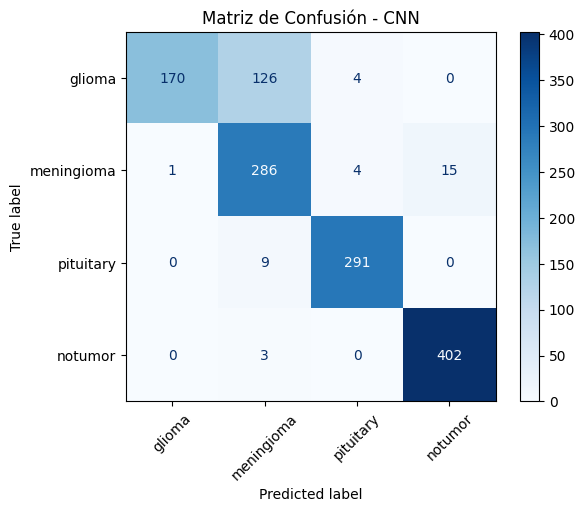

In [30]:
# Obtener las predicciones del modelo CNN en el conjunto de prueba
y_pred_cnn = np.argmax(cnn_model.predict(x_test), axis=-1)

# Definir las etiquetas de las clases (asegurarse de que coincidan con el orden)
class_labels = ['glioma', 'meningioma', 'pituitary', 'notumor']

# Matriz de confusión para el modelo CNN
cm_cnn = confusion_matrix(y_test, y_pred_cnn, labels=[0, 1, 2, 3])

# Visualizar la matriz de confusión
disp_cnn = ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=class_labels)
disp_cnn.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matriz de Confusión - CNN")
plt.show()

##2.2 Regularización L2 y Dropout

In [27]:
# Hiperparámetros
reg_strength = 0.001
dropout_rate = 0.3
num_classes = len(np.unique(y_train))

# Definición del modelo CNN
cnn_model2 = Sequential([
    Input(shape=x_train.shape[1:]),

    Conv2D(32, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(reg_strength)),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),

    Conv2D(64, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(reg_strength)),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),

    Flatten(),

    Dense(64, activation='relu',
          kernel_regularizer=regularizers.l2(reg_strength)),
    Dropout(dropout_rate),

    Dense(num_classes, activation='softmax')  # Salida multiclase
])

# Compilación
cnn_model2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Mostrar arquitectura
cnn_model2.summary()

# Callbacks
checkpoint = ModelCheckpoint("mejor_cnn_multiclase.keras",
                             monitor="val_accuracy",
                             save_best_only=True,
                             mode="max",
                             verbose=1)

early_stop = EarlyStopping(monitor='val_loss', patience=5,
                           restore_best_weights=True, verbose=1)

# Entrenamiento
history = cnn_model2.fit(
    x_train, y_train,
    batch_size=64,
    epochs=10,
    validation_data=(x_test, y_test),
    callbacks=[checkpoint, early_stop],
    verbose=2
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 198, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 99, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 99, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 99, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 49, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 49, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 116032)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │     7,426,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,445,764 (28.40 MB)

 Trainable params: 7,445,764 (28.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10

Epoch 1: val_accuracy improved from -inf to 0.66590, saving model to mejor_cnn_multiclase.keras
90/90 - 20s - 225ms/step - accuracy: 0.4930 - loss: 1.4360 - val_accuracy: 0.6659 - val_loss: 1.0300
Epoch 2/10

Epoch 2: val_accuracy improved from 0.66590 to 0.77879, saving model to mejor_cnn_multiclase.keras
90/90 - 5s - 60ms/step - accuracy: 0.7202 - loss: 0.8519 - val_accuracy: 0.7788 - val_loss: 0.7744
Epoch 3/10

Epoch 3: val_accuracy improved from 0.77879 to 0.81922, saving model to mejor_cnn_multiclase.keras
90/90 - 10s - 112ms/step - accuracy: 0.7908 - loss: 0.7040 - val_accuracy: 0.8192 - val_loss: 0.6093
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.81922
90/90 - 10s - 109ms/step - accuracy: 0.8174 - loss: 0.6205 - val_accuracy: 0.7979 - val_loss: 0.6389
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.81922
90/90 - 5s - 55ms/step - accuracy: 0.8358 - loss: 0.5809 - val_accuracy: 0.7994 - val_loss: 0.6158
Epoch 6/10

Epoch 6: val_accuracy improved 

In [28]:
# Obtener las probabilidades de predicción para el modelo CNN2 en el conjunto de prueba
y_pred_proba_cnn2 = cnn_model2.predict(x_test)

# Calcular el AUC utilizando las probabilidades predichas y las etiquetas reales
try:
    roc_auc_cnn2 = roc_auc_score(y_test, y_pred_proba_cnn2, multi_class='ovr', average='macro')
except ValueError as e:
    print(f"No se pudo calcular el AUC para el modelo CNN2. Error: {e}")
    print("Esto puede ocurrir si hay clases que no aparecen en las predicciones o en los datos reales.")
    roc_auc_cnn2 = None

# Evaluar el modelo en los datos de prueba
loss2, accuracy2 = cnn_model2.evaluate(x_test, y_test, verbose=0)

# Imprimir los resultados de la evaluación
print(f"Loss en los datos de prueba: {loss2:.4f}")
print(f"Precisión en los datos de prueba: {accuracy2:.4f}")
if roc_auc_cnn2 is not None:
    print(f"AUC en los datos de prueba: {roc_auc_cnn2:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
Loss en los datos de prueba: 0.4505
Precisión en los datos de prueba: 0.8841
AUC en los datos de prueba: 0.9836


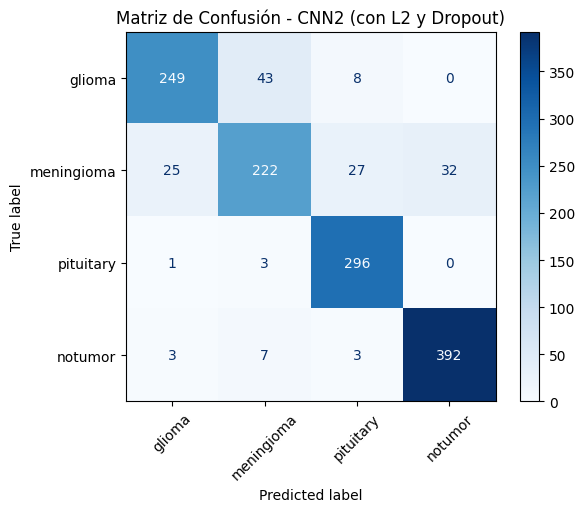

In [29]:
# Obtener las predicciones del modelo CNN2 en el conjunto de prueba
y_pred_cnn2 = np.argmax(y_pred_proba_cnn2, axis=-1)

# Definir las etiquetas de las clases (asegurarse de que coincidan con el orden)
class_labels = ['glioma', 'meningioma', 'pituitary', 'notumor']

# Matriz de confusión para el modelo CNN2
cm_cnn2 = confusion_matrix(y_test, y_pred_cnn2, labels=[0, 1, 2, 3])

# Visualizar la matriz de confusión
disp_cnn2 = ConfusionMatrixDisplay(confusion_matrix=cm_cnn2, display_labels=class_labels)
disp_cnn2.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matriz de Confusión - CNN2 (con L2 y Dropout)")
plt.show()

## 2.3 Comparativas

In [36]:
# Crear DataFrame de comparación solo para los dos modelos CNN
data_cnn = {
    'Modelo': ['CNN (base)', 'CNN (L2 + Dropout)'],
    'Accuracy (Test)': [accuracy, accuracy2],
    'AUC (Test)': [roc_auc_cnn, roc_auc_cnn2],
    'Loss (Test)': [loss, loss2]
}

df_cnn_comparison = pd.DataFrame(data_cnn)

# Mostrar la tabla comparativa
print("📊 Comparación de rendimiento entre modelos CNN:")
display(df_cnn_comparison)

📊 Comparación de rendimiento entre modelos CNN:


,Modelo,Accuracy (Test),AUC (Test),Loss (Test)
0,CNN (base),0.876430,0.984356,0.343882
1,CNN (L2 + Dropout),0.884058,0.983552,0.450482
